# Removing outliers from time series data

This notebook is a basic introduction to a specific aspect of time series data preparation; viz., removing outliers and replacing them with sensible values.

## 0 Setup

In [5]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load("forecast", "pracma", "TSA", "VIM", "zoo")

library(forecast)
library(pracma)
library(TSA)
library(VIM)
library(zoo)

## 1 Visualization

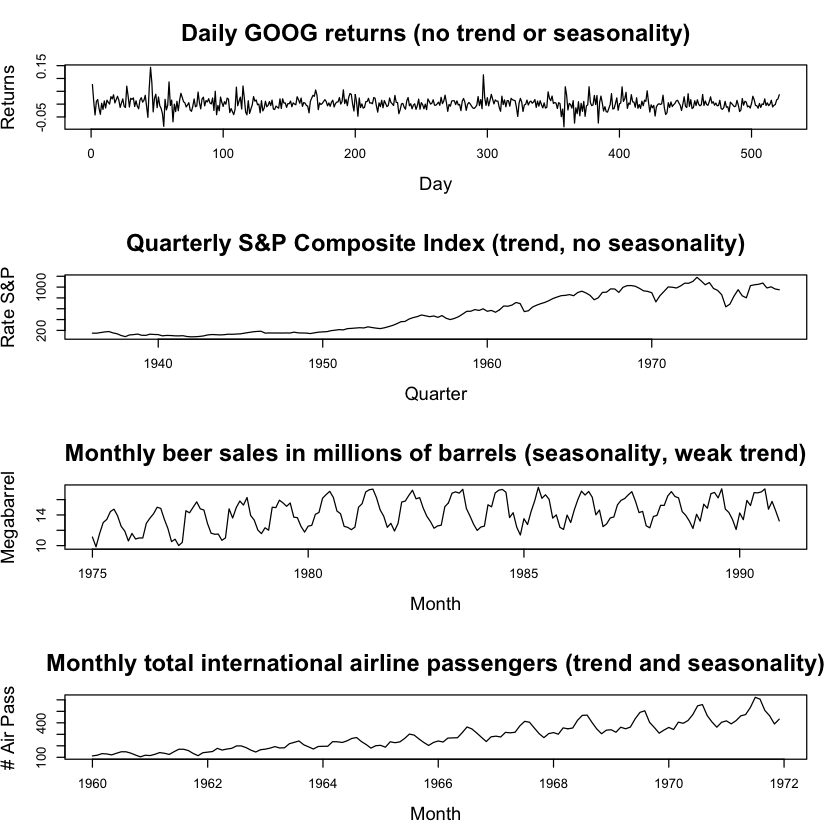

In [6]:
data(list = c("airpass", "SP", "google", "beersales"))
par(mfrow = c(4, 1), cex.main = 1.8, cex.lab = 1.4)
plot(google, main = "Daily GOOG returns (no trend or seasonality)",
     xlab = "Day", ylab = "Returns")
plot(SP, main = "Quarterly S&P Composite Index (trend, no seasonality)",
     xlab = "Quarter", ylab = "Rate S&P")
plot(beersales, main = "Monthly beer sales in millions of barrels (seasonality, weak trend)",
     xlab = "Month", ylab = "Megabarrel")
plot(airpass, main = "Monthly total international airline passengers (trend and seasonality)",
     xlab = "Month", ylab = "# Air Pass")

## 2 Introduce outliers

### 2.1 Daily GOOG returns

In [7]:
google.short <- subset(google, start=1, end=60)
google.times <- as.numeric(time(google.short))
google.lm <- lm(google.short ~ google.times)

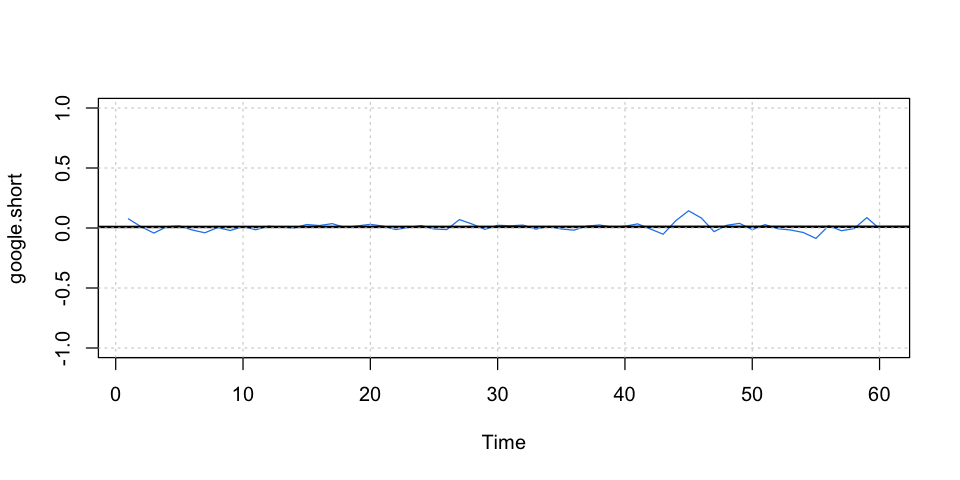

In [8]:
options(repr.plot.width=8, repr.plot.height=4)
plot(google.short, col="dodgerblue2", ylim=c(-1, 1))
abline(google.lm, lwd=2, col="black")
grid()

In [9]:
writeLines(paste("length(google.short) =", length(google.short)))

# Introduce outliers
google.with.outliers <- google.short
google.with.outliers[56] <- 10

# Linear model
google.with.outliers.lm <- lm(google.with.outliers ~ google.times)

length(google.short) = 60


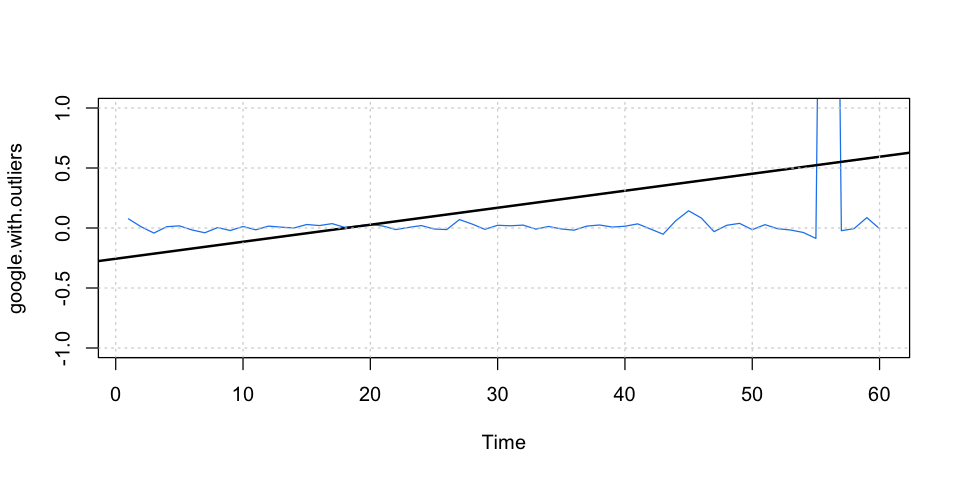

In [10]:
options(repr.plot.width=8, repr.plot.height=4)
plot(google.with.outliers, col="dodgerblue2", ylim=c(-1, 1))
abline(google.with.outliers.lm, lwd=2, col="black")
grid()

### 2.2 S&P

In [11]:
SP.times <- as.numeric(time(SP))
SP.lm <- lm(SP ~ SP.times)
SP.lm


Call:
lm(formula = SP ~ SP.times)

Coefficients:
(Intercept)     SP.times  
  -53076.46        27.38  


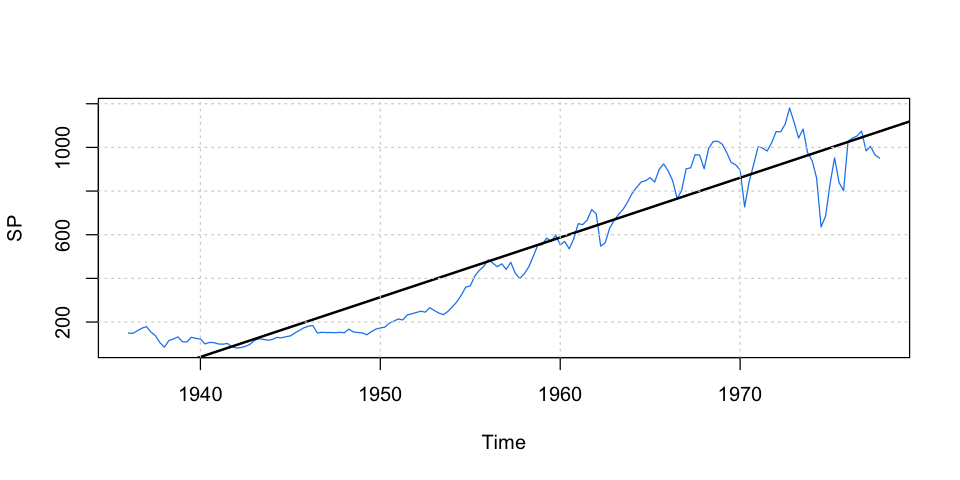

In [12]:
options(repr.plot.width=8, repr.plot.height=4)
plot(SP, col="dodgerblue2")
abline(SP.lm, lwd=2, col="black")
grid()

In [13]:
writeLines(paste("length(SP) =", length(SP)))

# Introduce outliers
SP.with.outliers <- SP
SP.with.outliers[113] <- 0
SP.with.outliers[145] <- 0
SP.with.outliers[161] <- 0

# Linear model
SP.with.outliers.lm <- lm(SP.with.outliers ~ SP.times)
SP.with.outliers.lm

length(SP) = 168



Call:
lm(formula = SP.with.outliers ~ SP.times)

Coefficients:
(Intercept)     SP.times  
   -49805.4         25.7  


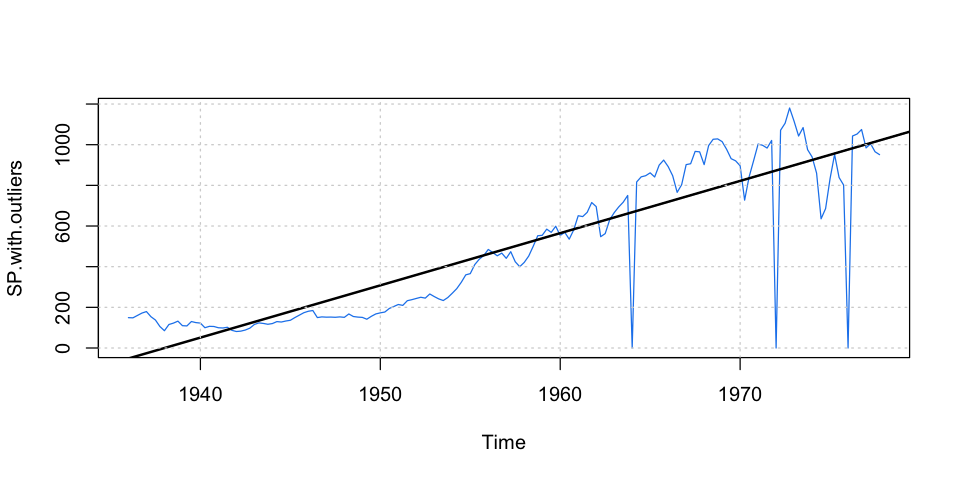

In [14]:
options(repr.plot.width=8, repr.plot.height=4)
plot(SP.with.outliers, col="dodgerblue2")
abline(SP.with.outliers.lm, lwd=2, col="black")
grid()

## 3 Identify outliers

In [15]:
# Run the Hampel filter
SP.hampel <- hampel(SP.with.outliers, 5, 3)

# Right now we're just identifying. We'll impute in a bit.
SP.hampel$ind

[1]  42  50 113 145 161

In [52]:
SP.hampel.outlier.times <- vector()
SP.hampel.outlier.values <- vector()

# Yes, I need to learn how to do functional programming in R. :D
i <- 1
for (ind in SP.hampel$ind) {
    SP.hampel.outlier.times[i] <- SP.times[ind]
    SP.hampel.outlier.values[i] <- SP.with.outliers[ind]
    i <- i + 1
}

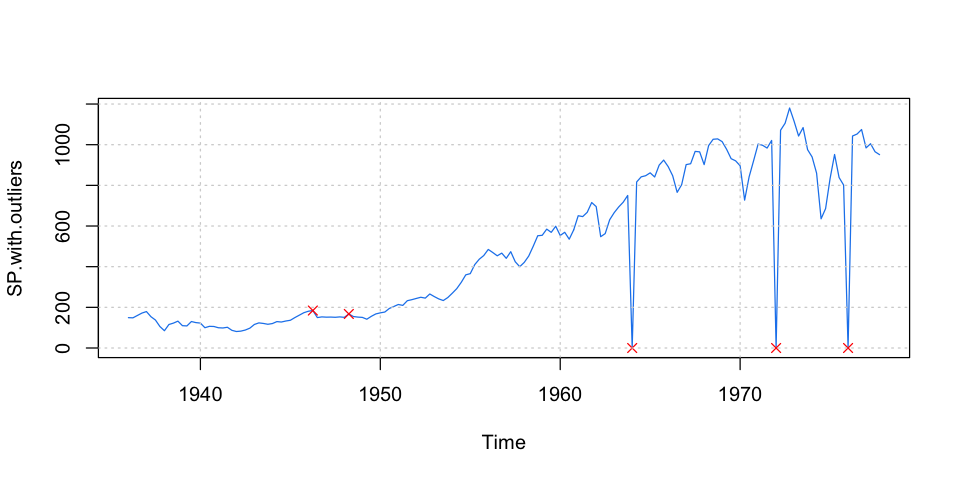

In [53]:
options(repr.plot.width=8, repr.plot.height=4)
plot(SP.with.outliers, col="dodgerblue2")
points(SP.hampel.outlier.times, SP.hampel.outlier.values, pch=4, col="red")
grid()

## 4 Imputation

There are lots of different imputation algos. We'll look at several here.

First, let's NA out the anomalies.

In [24]:
SP.with.NAs <- SP.with.outliers

i <- 1
for (ind in SP.hampel$ind) {
    SP.with.NAs[[ind]] <- NA
    i <- i + 1
}

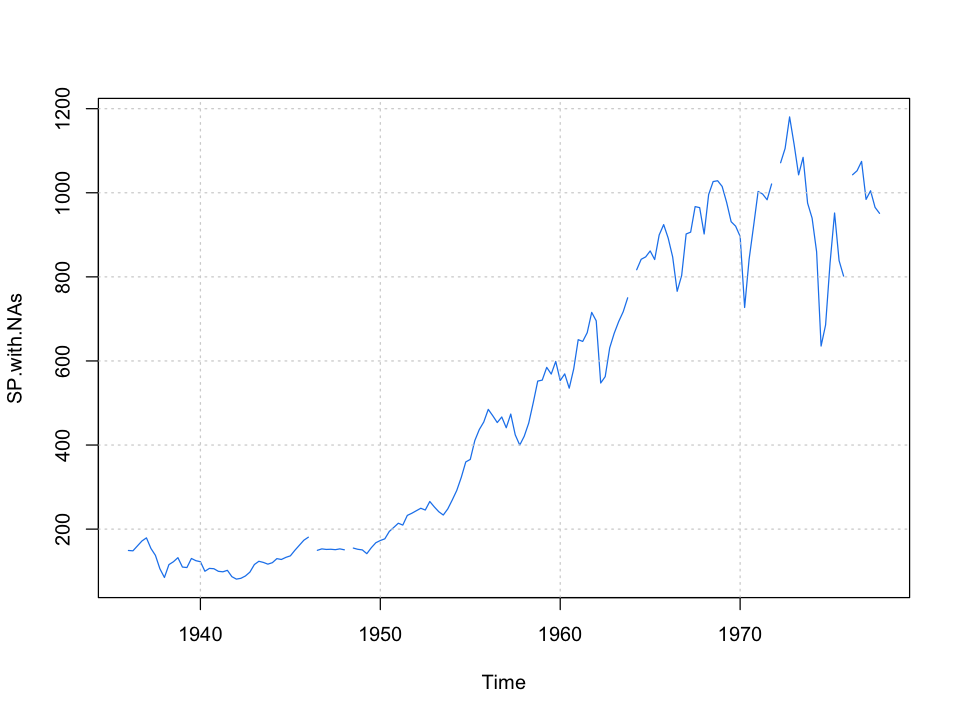

In [145]:
plot(SP.with.NAs, col="dodgerblue2")
grid()

### 4.1 na.aggregate (zoo)

This imputes by the overall mean.

In [130]:
SP.with.NAs.for.aggregate <- SP.with.NAs

# Impute
SP.imputed.aggregate <- na.aggregate(SP.with.NAs.for.aggregate)

# Collect the imputed points so we can highlight them
SP.imputed.aggregate.times <- vector()
SP.imputed.aggregate.values <- vector()
i <- 1
for (ind in SP.hampel$ind) {
    SP.imputed.aggregate.times[i] <- SP.times[ind]
    SP.imputed.aggregate.values[i] <- SP.imputed.aggregate[ind]
    i <- i + 1
}

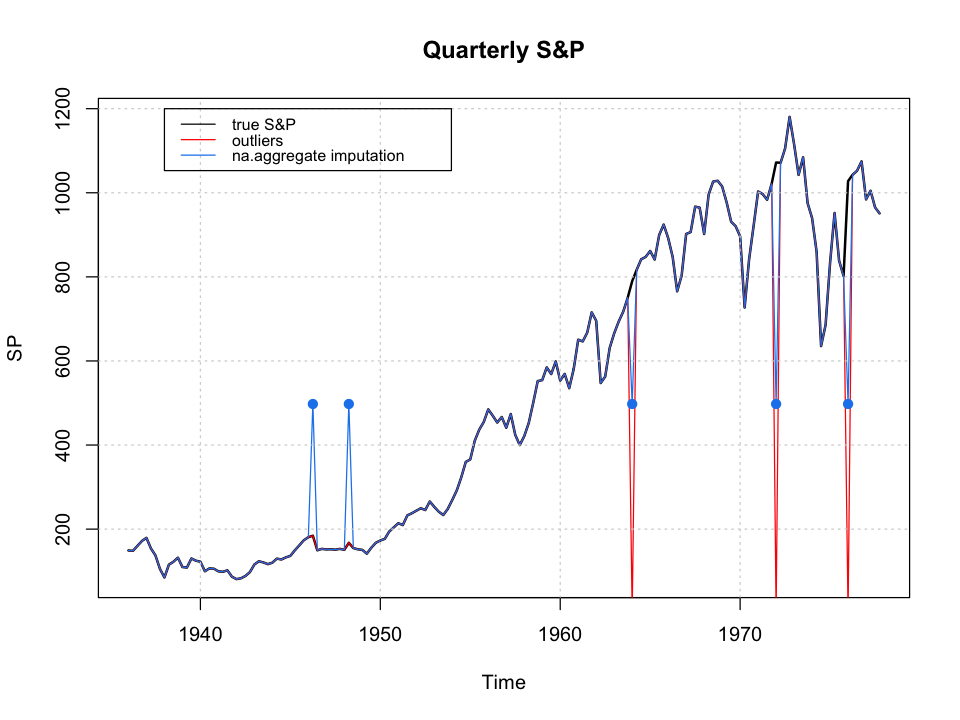

In [146]:
options(repr.plot.width=8, repr.plot.height=6)
plot(SP, col="black", lwd=2, main="Quarterly S&P")
lines(SP.with.outliers, lwd=1, col="red")
lines(SP.imputed.aggregate, lwd=1, col="dodgerblue2")
points(SP.imputed.aggregate.times, SP.imputed.aggregate.values, pch=19, col="dodgerblue2")
grid()
legend(1938, 1200, legend=c("true S&P", "outliers", "na.aggregate imputation"),
       col=c("black", "red", "dodgerblue2"), lty=1:1:1, cex=0.8)

### 4.2 na.locf (last observed carried forward) (zoo)

In [122]:
SP.with.NAs.for.locf <- SP.with.NAs

# Impute
SP.imputed.locf <- na.locf(SP.with.NAs.for.locf)

# Collect the imputed points so we can highlight them
SP.imputed.locf.times <- vector()
SP.imputed.locf.values <- vector()
i <- 1
for (ind in SP.hampel$ind) {
    SP.imputed.locf.times[i] <- SP.times[ind]
    SP.imputed.locf.values[i] <- SP.imputed.locf[ind]
    i <- i + 1
}

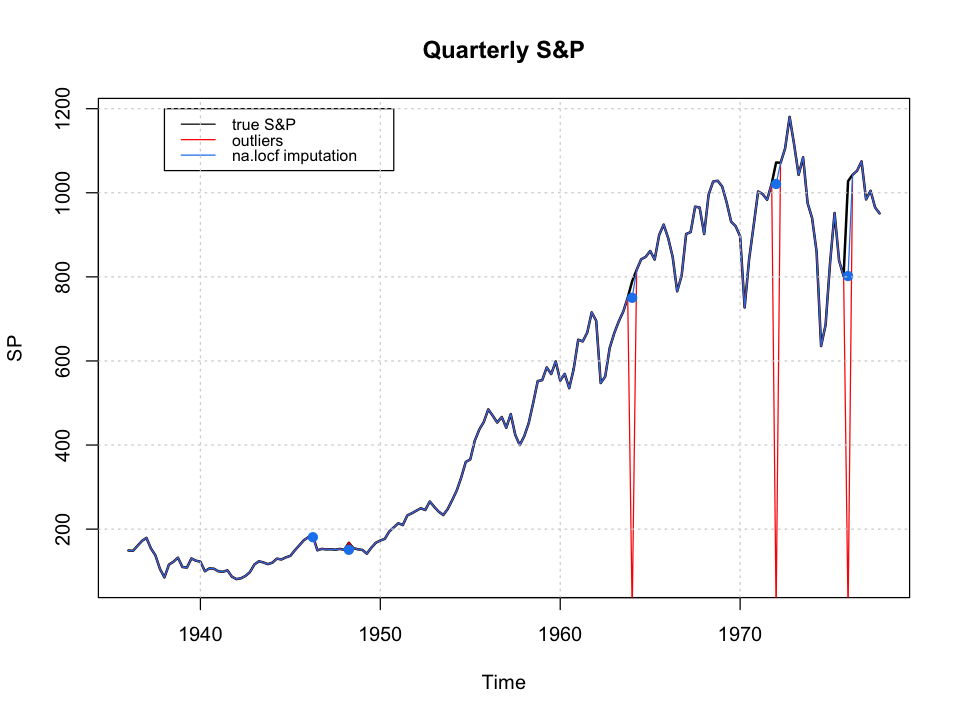

In [148]:
options(repr.plot.width=8, repr.plot.height=6)
plot(SP, col="black", lwd=2, main="Quarterly S&P")
lines(SP.with.outliers, lwd=1, col="red")
lines(SP.imputed.locf, lwd=1, col="dodgerblue2")
points(SP.imputed.locf.times, SP.imputed.locf.values, pch=19, col="dodgerblue2")
legend(1938, 1200, legend=c("true S&P", "outliers", "na.locf imputation"),
       col=c("black", "red", "dodgerblue2"), lty=1:1:1, cex=0.8)


### 4.3 na.interp (zoo)

Uses linear interpolation for non-seasonal series, and STL for seasonal series.

In [132]:
SP.with.NAs.for.interp <- SP.with.NAs

# Impute
SP.imputed.interp <- na.interp(SP.with.NAs.for.interp)

# Collect the imputed points so we can highlight them
SP.imputed.interp.times <- vector()
SP.imputed.interp.values <- vector()
i <- 1
for (ind in SP.hampel$ind) {
    SP.imputed.interp.times[i] <- SP.times[ind]
    SP.imputed.interp.values[i] <- SP.imputed.interp[ind]
    i <- i + 1
}

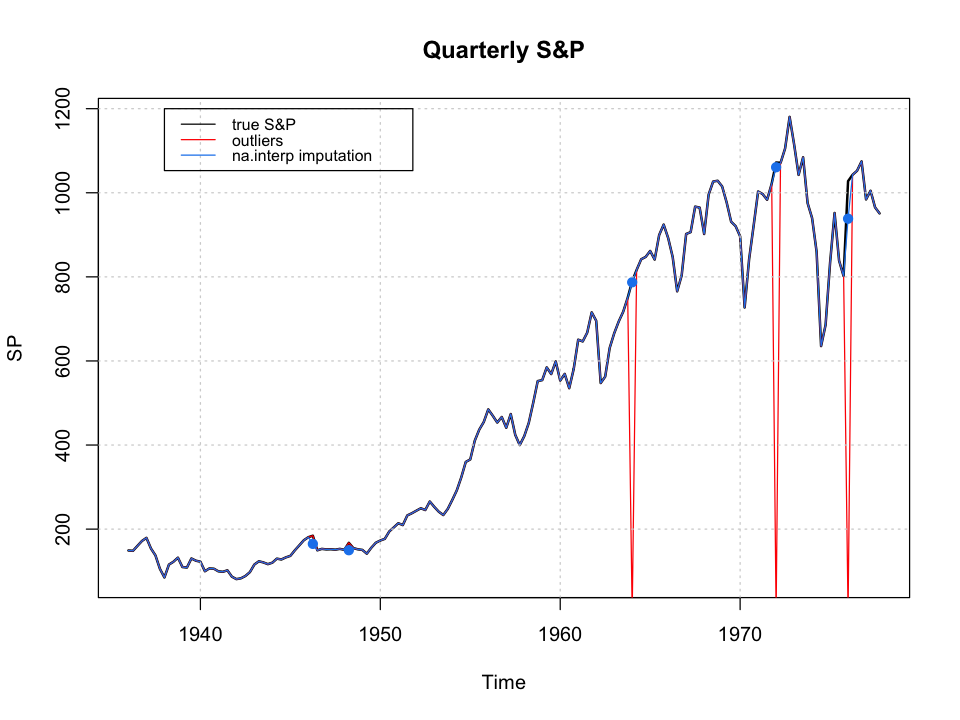

In [149]:
options(repr.plot.width=8, repr.plot.height=6)
plot(SP, col="black", lwd=2, main="Quarterly S&P")
lines(SP.with.outliers, lwd=1, col="red")
lines(SP.imputed.interp, lwd=1, col="dodgerblue2")
points(SP.imputed.interp.times, SP.imputed.interp.values, pch=19, col="dodgerblue2")
grid()
legend(1938, 1200, legend=c("true S&P", "outliers", "na.interp imputation"),
       col=c("black", "red", "dodgerblue2"), lty=1:1:1, cex=0.8)

### 4.4 Hampel imputation (pracma)

It turns out that the Hampel function we did earlier performs not only outlier identification, but also replaces the outliers with imputed values. The imputed value is the median of the Hampel window.

In [142]:
# We already did the imputation.
SP.imputed.hampel <- SP.hampel$y

# Collect the imputed points so we can highlight them
SP.imputed.hampel.times <- vector()
SP.imputed.hampel.values <- vector()
i <- 1
for (ind in SP.hampel$ind) {
    SP.imputed.hampel.times[i] <- SP.times[ind]
    SP.imputed.hampel.values[i] <- SP.imputed.hampel[ind]
    i <- i + 1
}

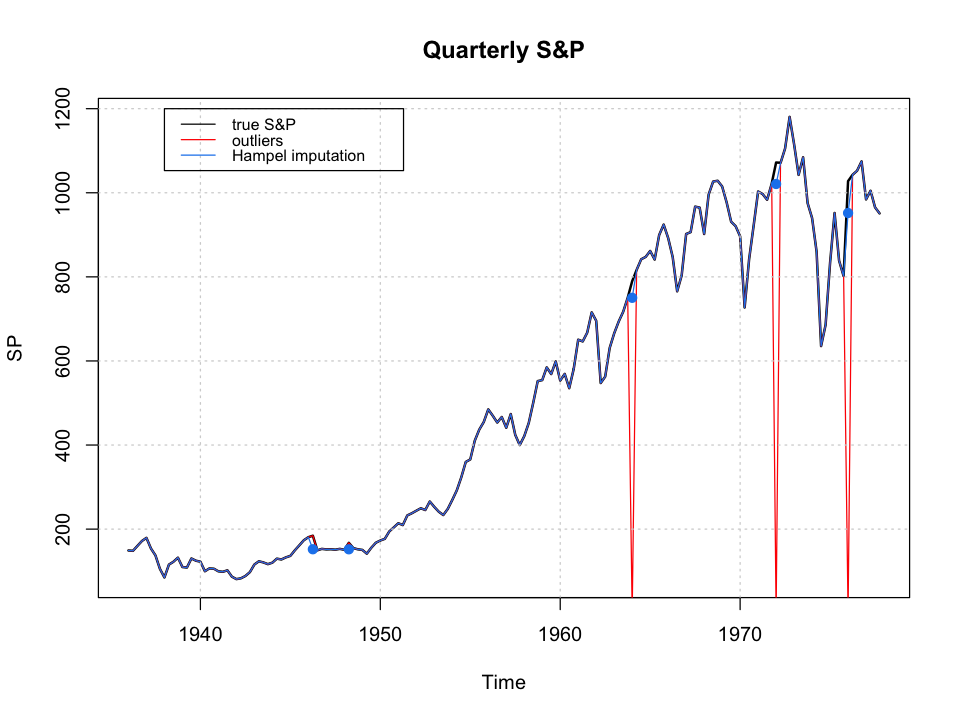

In [150]:
options(repr.plot.width=8, repr.plot.height=6)
plot(SP, col="black", lwd=2, main="Quarterly S&P")
lines(SP.with.outliers, lwd=1, col="red")
lines(SP.imputed.hampel, lwd=1, col="dodgerblue2")
points(SP.imputed.hampel.times, SP.imputed.hampel.values, pch=19, col="dodgerblue2")
grid()
legend(1938, 1200, legend=c("true S&P", "outliers", "Hampel imputation"),
       col=c("black", "red", "dodgerblue2"), lty=1:1:1, cex=0.8)